<a href="https://colab.research.google.com/github/fzohrasmaili/gene_promoter_regression/blob/main/Neural_Motif_Discovery_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install modisco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.3/217.3 KB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.7 MB/s eta 0:00:00
  Created wheel for modisco: filename=modisco-0.5.16.0-py3-none-any.whl size=233643 sha256=4b47e0d46c8cb0dfa56ef387b5b41e118e09bc68305f2f16b244a12d93fbeebe
  Stored in directory: /root/.cache/pip/wheels/29/42/23/044d8232bfb54e734b4d7964df27f7129f1ab0a20ed85e399c
Successfully built modisco


In [ ]:
! pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00


In [ ]:
import io
from google.colab import files
#
uploaded = files.upload()

Saving models.py to models.py
Saving functions.py to functions.py


In [ ]:
uploaded = files.upload()

Saving 3000_data_Y to 3000_data_Y
Saving 3000_data_X to 3000_data_X


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from models import * 
from functions import *
from random import choices
import statistics
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

Load Model

In [ ]:
seq_length = 2000
n_seq = 1500
output_sz=1
LV = 14

In [ ]:

data_X = file_to_list(f"3000_data_X").float()
data_size = int(data_X.size()[0])
data_X_new= torch.transpose(data_X,1,2)
data_X_CNN = data_X_new.view(data_size,4,seq_length)
data_Y = torch.from_numpy(numpy.loadtxt(f"3000_data_Y")[:,LV]).float()
data_X0 = data_X_CNN[0:n_seq]
data_Y0 = data_Y[0:n_seq].unsqueeze(dim=1)
print (data_X0.size())
print (data_Y0.size())

torch.Size([1500, 4, 2000])
torch.Size([1500, 1])


In [ ]:
uploaded_model = files.upload()

Saving Alastor_LV_14.pt to Alastor_LV_14.pt


In [ ]:
alastor_S = Alastor()
ALASTOR_model_PATH = f"Alastor_LV_{LV}.pt"
alastor_S.load_state_dict(torch.load(ALASTOR_model_PATH))
alastor_S.eval()

Alastor(
  (conv_block_1): Sequential(
    (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv1d(32, 48, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv_block_3): Sequential(
    (0): Conv1d(48, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.4, inplace=False)
  )
  (dilatio

Get sequences

In [ ]:
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
scores = alastor_S(data_X0)

generate reference sequence

In [ ]:

nucleotides = [1, 2, 3, 4] # A, T, C, G
probabilities =[0.3, 0.2, 0.2, 0.3]
num =choices(nucleotides, probabilities, k=2000)
ref_tensor = decimal_to_binary_tensor(num,4).float()
print (ref_tensor.size())
ref_sequence = ref_tensor.view(1,4,2000)
print (ref_sequence)


torch.Size([2000, 4])
tensor([[[0., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 0., 0.]]])


In [ ]:
attr_list=[]
seq_list = []
for i in range(7):
    x = data_X0[i].view(1,4,2000)
    dl = DeepLift(alastor_S)
    #print (ref_sequence.size())
    #print (x.size())
    attributions, delta = dl.attribute(x, ref_sequence, target=0, return_convergence_delta=True)
    #print('DeepLift Attributions:', attributions)
    attr_list.append (attributions)
    seq_list.append (x)
attr_stack = torch.stack(attr_list)
seq_stack = torch.stack(seq_list)
print (attr_stack.size())
print (seq_stack.size())
    



torch.Size([7, 1, 4, 2000])
torch.Size([7, 1, 4, 2000])


Mean-normalize contribution scores

In [ ]:
norm_attr_list = list(attr_stack-torch.mean(attr_stack))

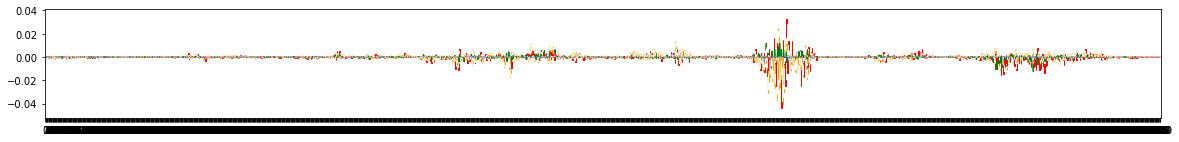

In [ ]:

import modisco
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(attr_list[1].detach().numpy())

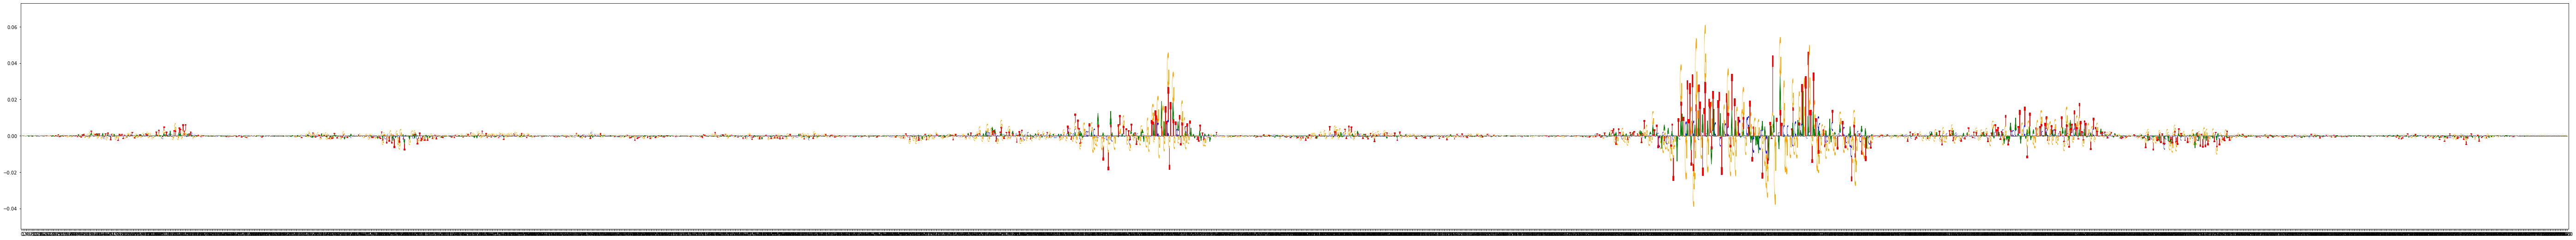

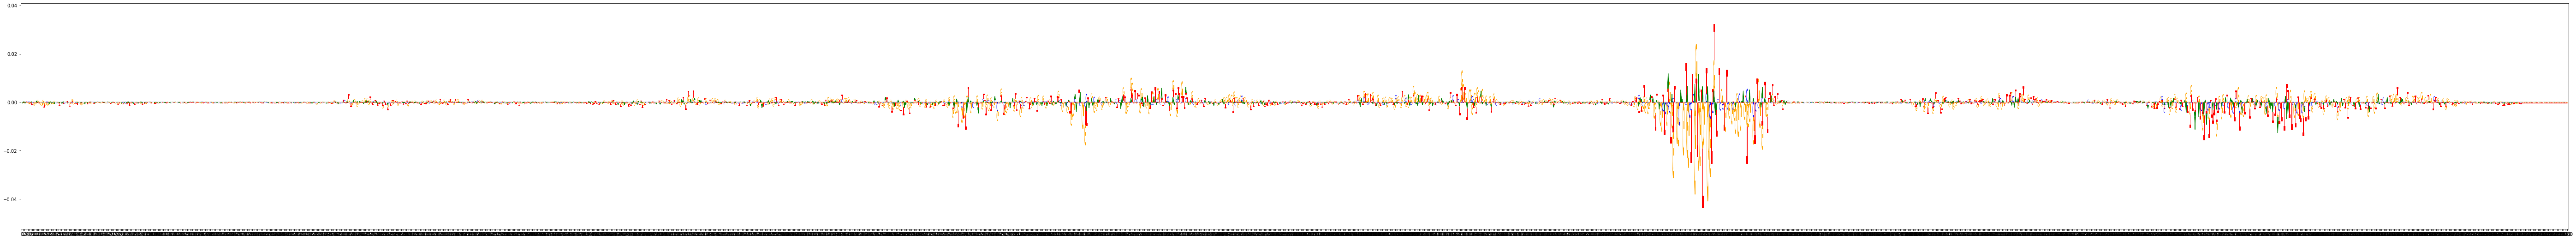

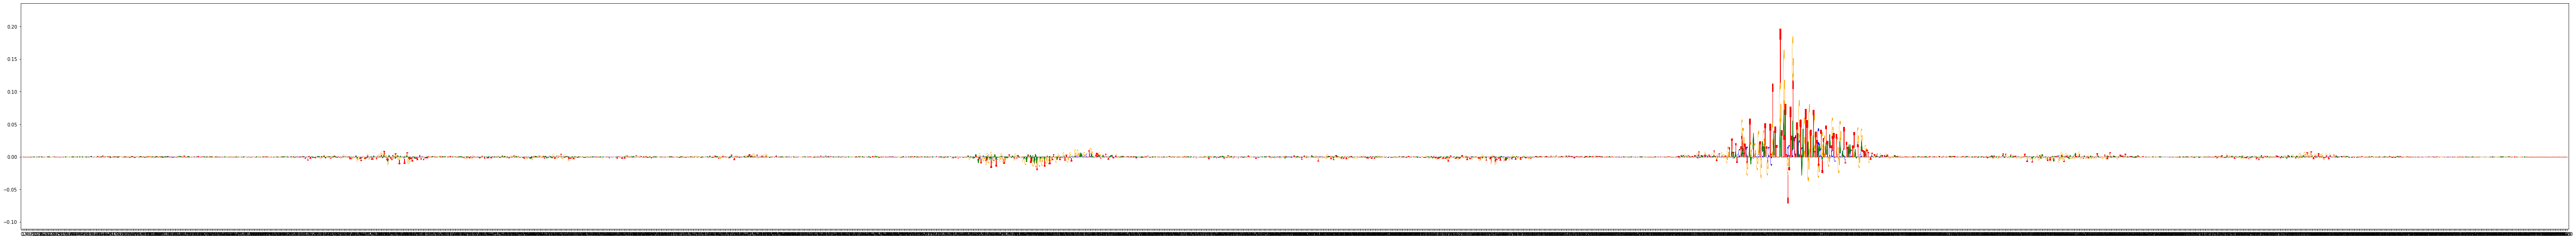

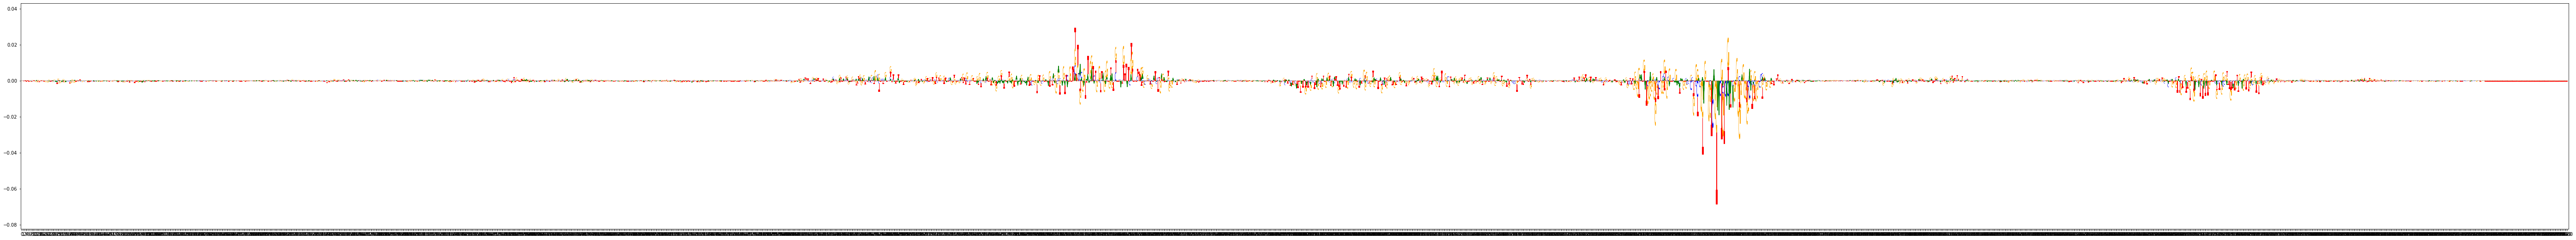

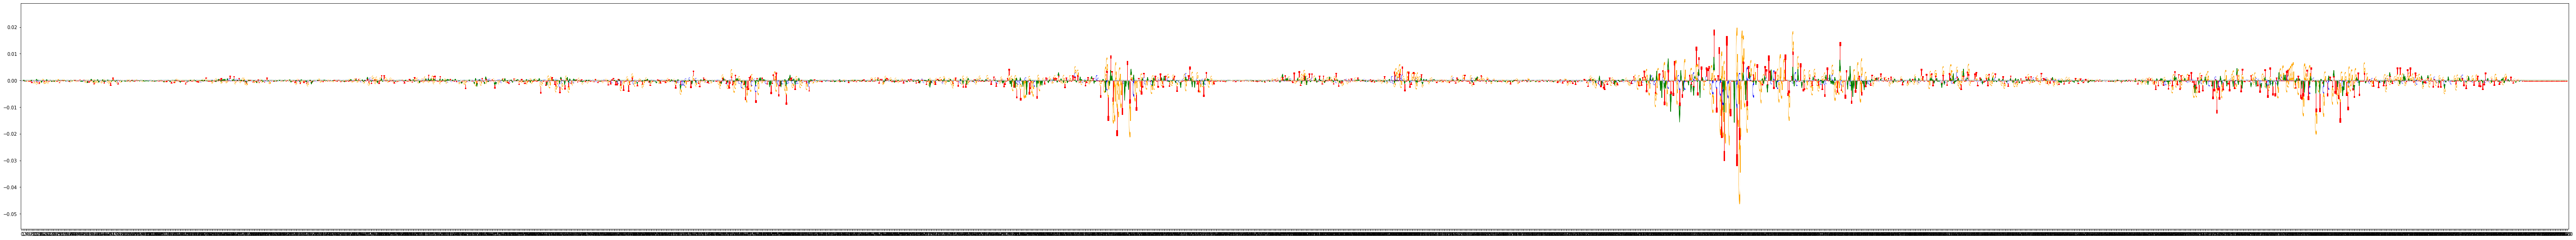

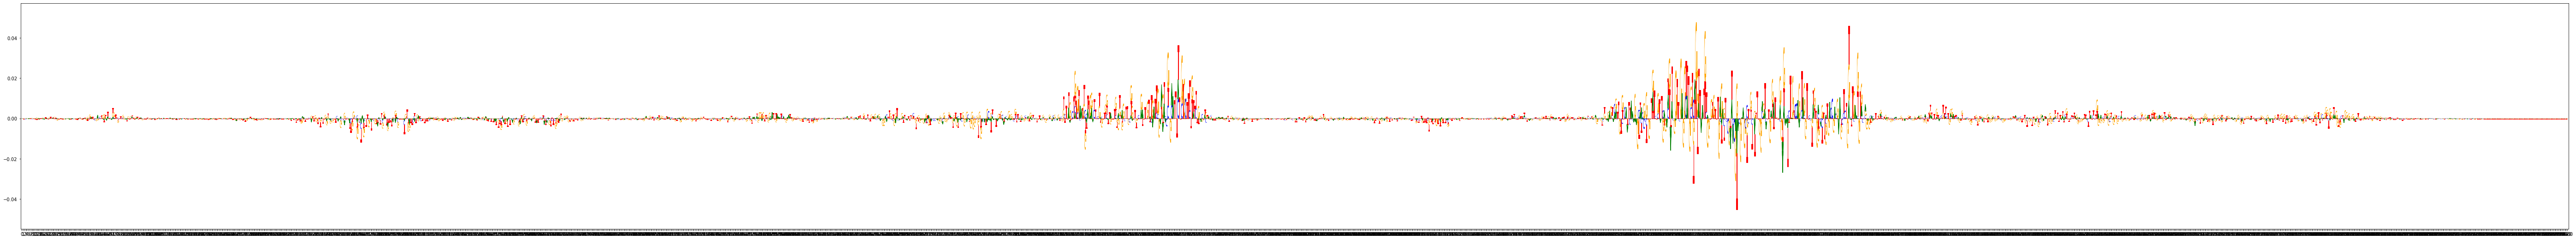

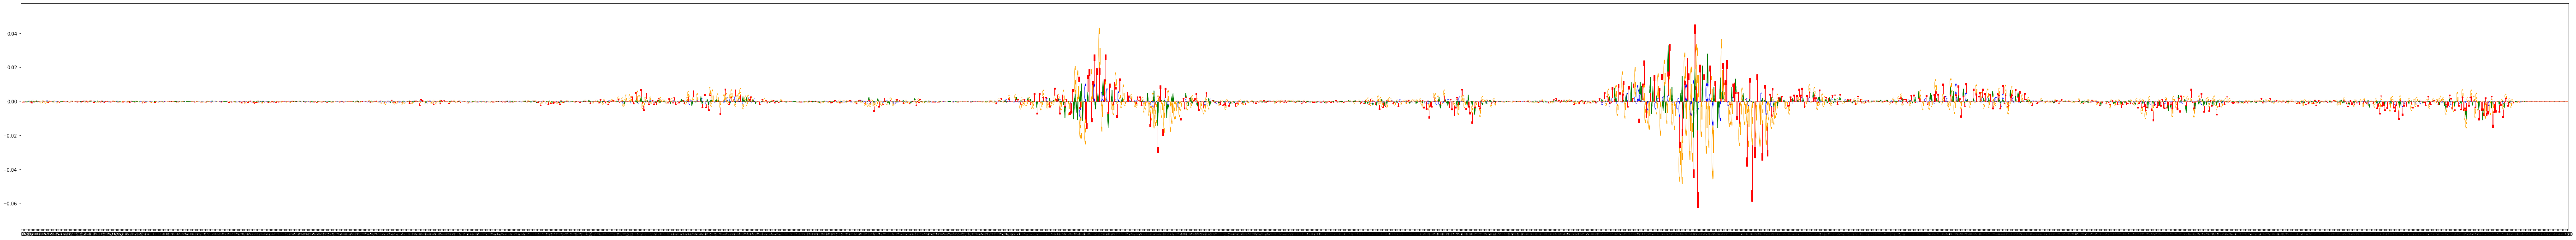

In [ ]:
import modisco
from modisco.visualization import viz_sequence
for i in range(len(norm_attr_list)):
  #viz_sequence.plot_weights(attr_list[i].detach().numpy(),figsize=(20,4))
  viz_sequence.plot_weights(norm_attr_list[i].detach().numpy(),figsize=(99,9))